# DASH Investment Report


##### This report provides a structured financial analysis of DoorDash (DASH) using historical stock price data. The dataset used in this analysis contains historical stock data for DoorDash (DASH) from Dec 2020 to June 2025. It includes daily records of the stock’s open, high, low, and close prices, as well as trading volume. The analysis involves cleaning the dataset, engineering key financial features, visualising key metrics, and concluding with an investment recommendation based on the findings.

## Step 1: Load and Prepare Data

The `pandas` library is used for data handling and `numpy` for advanced calculations such as logarithmic transformations. The dataset is read into a DataFrame using `pd.read_csv()`.

Basic structural information is displayed using `df.info()`, and the first five rows of the dataset are shown using `df.head()` to verify successful import and observe the format.


In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv("DASH_A1.csv")

# Display basic info and preview
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184 entries, 0 to 1183
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1184 non-null   object 
 1   Close   1159 non-null   float64
 2   High    1160 non-null   float64
 3   Low     1168 non-null   float64
 4   Open    1167 non-null   float64
 5   Volume  1158 non-null   float64
dtypes: float64(5), object(1)
memory usage: 55.6+ KB


(None,
          Date       Close        High         Low        Open     Volume
 0  24-02-2022  100.419998  100.919998   85.177002   86.879997  6639000.0
 1  01-08-2024  108.199997  112.769997  105.905998  108.620003  7965400.0
 2  11-02-2025  193.089996  194.000000  189.500000  190.919998  6771900.0
 3  13-04-2021  149.460007  150.360001  143.550003  146.839996  2823500.0
 4  17-09-2024  129.880005  131.369995  126.900002  131.350006  2825500.0)

The dataset consists of 1,184 rows and 6 columns. It includes daily stock information for DoorDash (DASH), with the following columns: `Date`, `Close`, `High`, `Low`, `Open`, and `Volume`. Among them, the `Date` column is initially stored as an object type and requires conversion to datetime format for time series analysis. The remaining columns are of type `float64`.

## Step 2: Data Cleaning


The `"Date"` column is first converted from string format to datetime format using `pd.to_datetime()` with the specified day-month-year format. The dataset is then sorted chronologically by date, and the index is reset to reflect the new order.

Next, duplicate rows are identified using `df.duplicated().sum()` to count their number. To ensure data consistency, any duplicate records are removed using `df.drop_duplicates(inplace=True)`. A second check is performed afterward to confirm that no duplicates remain in the dataset.


This section addresses missing values: 

- The **"Open"** column is forward-filled using the previous day's **"Close"** value, reflecting the assumption that in the absence of overnight news or after-hours trading, the market opens at the same level it previously closed. 

- The **"Close"** column is also forward-filled. However, the primary concern here is to avoid look-ahead bias where future data incorrectly influences past observations. Forward-filling, here, ensures that only past information is used at any given point in time. 

- For the **"High"** and **"Low"** columns, missing values are imputed using the monthly mean of available data within the same month. This assumes that high and low prices follow patterns and replacing them with an average across similar time periods maintains integrity while smoothing volatility.

- The **"Volume"** column is filled using a conditional logic:
  - If **"Open"** is equal to **"Close"**, this implies minimal or no trading activity occurred during that day. In such cases, missing volume is set to zero. 
  - If **"Open"** and **"Close"** differ, there was likely trading activity. Missing volume in such cases is replaced with the median of the existing volume data.

`np.nan` is used to represent missing values in numerical arrays. These are systematically replaced using the logic above.



In [12]:
# Convert Date column to datetime and sort
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Count the duplicates  
df.duplicated().sum()

# Get rid of the duplicates
df.drop_duplicates()

# But make sure to update the variable to save the work
df.drop_duplicates(inplace=True)

# Count the duplicates
df.duplicated().sum()

# Fill missing Open values with previous day's Close
df["Open"] = df["Open"].fillna(method="ffill")

# Fill missing Close values using forward-fill
df["Close"] = df["Close"].fillna(method="ffill")

# Fill missing High/Low with monthly mean
df["Month"] = df["Date"].dt.to_period("M")
df["High"] = df.groupby("Month")["High"].transform(lambda x: x.fillna(x.mean())) # A lambda function is used here to apply mean-based imputation for each monthly group
df["Low"] = df.groupby("Month")["Low"].transform(lambda x: x.fillna(x.mean())) # A lambda function is used here to apply mean-based imputation for each monthly group

# Fill missing Volume values using conditional rules
volume_median = df["Volume"].median()

def fill_volume(row):
    if pd.notnull(row["Volume"]): # If-elif is used here to ensure that only the first true condition is executed making the code more readable
        return row["Volume"]
    elif row["Open"] == row["Close"]:
        return 0
    else:
        return volume_median

df["Volume"] = df.apply(fill_volume, axis=1)

# Drop the helper "Month" column, it was a temporary helper column used for monthly grouping, it is no longer needed
df.drop(columns=["Month"], inplace=True)

# Summary of missing values after cleaning
missing_summary = df.isnull().sum()
missing_summary




/tmp/ipykernel_3177/246846517.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Open"] = df["Open"].fillna(method="ffill")
/tmp/ipykernel_3177/246846517.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Close"] = df["Close"].fillna(method="ffill")


Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


After the cleaning process, all remaining missing values were eliminated, as confirmed by the `missing_summary` table. Each column now contains zero null values, indicating that the dataset is complete and ready for further analysis.


## Step 3: Feature Engineering

This section creates additional columns to support deeper financial analysis:

- **Simple Return**: Measures the percentage change in **"Close"** prices.
- **Log Return**: Computed using `numpy.log` due to log returns being additive over time.
- **20-Day Momentum**: Calculated as the difference between today’s and the 20-days-ago close price.
- **20-Day Simple Moving Average (SMA)**: A rolling mean used to smooth short-term price fluctuations.
- **20-Day Rolling Volatility**: The rolling standard deviation of daily returns, used to estimate short-term risk.
- **Bollinger Bands**: Constructed as ±2 standard deviations around the 20-day moving average to indicate volatility thresholds.
- **Weekday**: Extracted from the "Date" column to enable weekday-based return analysis.
- **Price Surge**: A binary column that flags days when the simple return exceeds the mean by more than 4 standard deviations.
- **Volume Spike**: A binary column that flags unusually high volume days, defined as exceeding the mean by more than 6 standard deviations.

In [13]:
# 1. Simple Daily Returns
df["Simple Return"] = df["Close"].pct_change()

# 2. Logarithmic Returns
df["Log Return"] = np.log(df["Close"] / df["Close"].shift(1))

# 3. 20-Day Momentum
df["20D Momentum"] = df["Close"] - df["Close"].shift(20)

# 4. 20-Day Simple Moving Average
df["20D SMA"] = df["Close"].rolling(window=20).mean()

# 5. 20-Day Rolling Volatility
df["20D Volatility"] = df["Simple Return"].rolling(window=20).std()

# 6. Day of the Week
df["Weekday"] = df["Date"].dt.day_name()

# 7. Price Surge Identification
mean_return = df["Simple Return"].mean()
std_return = df["Simple Return"].std()
df["Price Surge"] = df["Simple Return"] > (mean_return + 4 * std_return)

# 8. Volume Spike Identification
mean_volume = df["Volume"].mean()
std_volume = df["Volume"].std()
df["Volume Spike"] = df["Volume"] > (mean_volume + 6 * std_volume)

# 9. Bollinger Bands Calculation 
df["Dev"] = df["Close"].rolling(window=20).std()
df["Upper Band"] = df["20D SMA"] + 2 * df["Dev"]
df["Lower Band"] = df["20D SMA"] - 2 * df["Dev"]


df

,Date,Close,High,Low,Open,Volume,Simple Return,Log Return,20D Momentum,20D SMA,20D Volatility,Weekday,Price Surge,Volume Spike,Dev,Upper Band,Lower Band
0,2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700.0,NaN,NaN,NaN,NaN,NaN,Wednesday,False,False,NaN,NaN,NaN
1,2020-12-10,186.000000,187.695007,172.636002,179.710007,3506800.0,-0.018521,-0.018695,NaN,NaN,NaN,Thursday,False,False,NaN,NaN,NaN
2,2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600.0,-0.059140,-0.060961,NaN,NaN,NaN,Friday,False,False,NaN,NaN,NaN
3,2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600.0,-0.085714,-0.089612,NaN,NaN,NaN,Monday,False,False,NaN,NaN,NaN
4,2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000.0,-0.006938,-0.006962,NaN,NaN,NaN,Tuesday,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300.0,-0.004395,-0.004404,33.970001,206.409998,0.017753,Monday,False,False,7.886279,222.182556,190.637440
1180,2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700.0,-0.011587,-0.011654,22.869995,207.553498,0.015859,Tuesday,False,False,7.341377,222.236252,192.870744
1181,2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500.0,0.013165,0.013079,20.000000,208.553498,0.014953,Wednesday,False,False,7.304940,223.163377,193.943619
1182,2025-06-12,216.600006,219.419998,215.675003,218.080002,2510400.0,-0.005510,-0.005525,19.760010,209.541499,0.014976,Thursday,False,False,6.965698,223.472894,195.610103


Due to the use of rolling and shifting functions, some of the newly created columns contain missing values at the beginning of the dataset. Specifically, the first 19 rows of `20D SMA` are null, while the first 20 rows of `20D Momentum` and `20D Volatility` are also null. 

## Step 4: Key Dates Identification

This section focuses on identifying significant trading dates for each calendar year. These dates help highlight periods of extreme price movement, volatility, and market activity, all of which are relevant for understanding historical risk and performance patterns.

The following metrics are calculated annually:

- **Highest Volatility Day**: The trading day with the highest 20-day rolling standard deviation of returns.
- **Largest Price Surge**: The day with the highest single-day return (maximum positive simple return).
- **Largest Price Drop**: The day with the most negative return (maximum loss in a single day).
- **Highest Volume Day**: The day with the highest recorded trading volume.
- **Highest High / Lowest Low**: The peak and bottom prices reached during the year.
- **Annual Open and Close**: The opening price on the first trading day and the closing price on the last trading day of each year.

In [14]:
# Extract year
df["Year"] = df["Date"].dt.year

# Define function to extract key dates
def extract_key_dates(group):
    result = {}

    # Highest Volatility
    vol_group = group.dropna(subset=["20D Volatility"])
    if not vol_group.empty:
        result["Highest Volatility Date"] = vol_group.loc[vol_group["20D Volatility"].idxmax(), "Date"]
        result["Highest Volatility Value"] = vol_group["20D Volatility"].max()
    else:
        result["Highest Volatility Date"] = np.nan
        result["Highest Volatility Value"] = np.nan

    # Largest Price Surge
    return_group = group.dropna(subset=["Simple Return"])
    if not return_group.empty:
        result["Largest Price Surge Date"] = return_group.loc[return_group["Simple Return"].idxmax(), "Date"]
        result["Largest Price Surge Value"] = return_group["Simple Return"].max()

        result["Largest Price Drop Date"] = return_group.loc[return_group["Simple Return"].idxmin(), "Date"]
        result["Largest Price Drop Value"] = return_group["Simple Return"].min()
    else:
        result["Largest Price Surge Date"] = result["Largest Price Drop Date"] = np.nan
        result["Largest Price Surge Value"] = result["Largest Price Drop Value"] = np.nan

    # Highest Volume
    volume_group = group.dropna(subset=["Volume"])
    if not volume_group.empty:
        result["Highest Volume Date"] = volume_group.loc[volume_group["Volume"].idxmax(), "Date"]
        result["Highest Volume Value"] = volume_group["Volume"].max()
    else:
        result["Highest Volume Date"] = result["Highest Volume Value"] = np.nan

  # Highest High / Lowest Low
    high_group = group.dropna(subset=["High"])
    low_group = group.dropna(subset=["Low"])
    if not high_group.empty:
        result["Highest High Date"] = high_group.loc[high_group["High"].idxmax(), "Date"]
        result["Highest High Value"] = high_group["High"].max()
    else:
        result["Highest High Date"] = result["Highest High Value"] = np.nan

    if not low_group.empty:
        result["Lowest Low Date"] = low_group.loc[low_group["Low"].idxmin(), "Date"]
        result["Lowest Low Value"] = low_group["Low"].min()
    else:
        result["Lowest Low Date"] = result["Lowest Low Value"] = np.nan

    # Annual Open and Close
    if not group.empty:
        result["Year Open"] = group.iloc[0]["Open"]
        result["Year Close"] = group.iloc[-1]["Close"]
    else:
        result["Year Open"] = result["Year Close"] = np.nan

    return pd.Series(result)

key_dates_df = df.groupby("Year").apply(extract_key_dates).reset_index()

key_dates_df

/tmp/ipykernel_3177/2833336055.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  key_dates_df = df.groupby("Year").apply(extract_key_dates).reset_index()


,Year,Highest Volatility Date,Highest Volatility Value,Largest Price Surge Date,Largest Price Surge Value,Largest Price Drop Date,Largest Price Drop Value,Highest Volume Date,Highest Volume Value,Highest High Date,Highest High Value,Lowest Low Date,Lowest Low Value,Year Open,Year Close
0,2020,NaT,NaN,2020-12-18,0.078724,2020-12-14,-0.085714,2020-12-09,25373700.0,2020-12-09,195.500000,2020-12-31,135.380005,182.000000,142.750000
1,2021,2021-05-20,0.067393,2021-05-14,0.221491,2021-02-22,-0.135457,2021-03-09,20400000.0,2021-11-15,257.250000,2021-05-13,110.129997,142.500000,148.899994
2,2022,2022-06-01,0.080994,2022-03-16,0.134512,2022-05-11,-0.131621,2022-02-17,47405700.0,2022-01-12,152.494995,2022-10-24,41.365002,149.610001,48.820000
3,2023,2023-11-06,0.047470,2023-11-02,0.156653,2023-02-17,-0.075946,2023-12-15,30556000.0,2023-12-11,103.980003,2023-01-06,45.931999,49.980000,98.889999
4,2024,2024-02-27,0.033547,2024-08-02,0.083457,2024-05-02,-0.103170,2024-05-02,22134800.0,2024-12-17,181.779999,2024-01-04,93.330002,97.800003,167.750000
5,2025,2025-04-10,0.048324,2025-04-09,0.137738,2025-04-03,-0.080634,2025-03-21,73637400.0,2025-06-06,220.880005,2025-04-07,155.399994,168.789993,218.119995


### Key Date Summary Overview

The summary table provides a year-by-year breakdown of key trading indicators for DoorDash (DASH) from 2020 to 2024. Several observations can be made:

- **2022 recorded the highest volatility** across all years, with a 20-day rolling standard deviation of 0.081 on 1 June. This indicates significant price uncertainty during that period.
- **The largest single-day return (+22.15%) occurred on 14 May 2021**, while the largest one-day loss (−13.55%) was observed on 22 February 2021.
- **Trading volume peaked in 2022**, with 47.4 million shares traded on 17 February. Other years also showed local highs, such as 30.5 million in December 2023.
- **The all-time high price of $257.25** was reached on 15 November 2021, while the lowest price ($41.37) occurred on 24 October 2022.
- In terms of annual performance, **2022 saw the sharpest decline**, opening at $149.61 and closing at $48.82 (a loss of over 67%). Conversely, **2023 showed partial recovery**, closing the year at $98.89.



## Step 5: Data Visualization

In this section, multiple visualizations are constructed to explore DASH’s price dynamics and trading activity: 

- Closing prices are plotted with the simple moving average and Bollinger Bands to highlight trends and detect periods of high or low volatility.
- Daily trading volume and rolling volatility are shown in subplots beneath the main chart, all sharing a common x-axis, to observe how market activity and risk evolve over time.
- A histogram displays the distribution of log returns to evaluate the return profile and detect skewness or fat tails.
- A scatter plot illustrates the relationship between trading volume and daily returns, helping assess whether higher volume corresponds to larger price moves.

Visualizations are created using `matplotlib.pyplot`. The `gridspec_kw` parameter is used to allocate more vertical space to the main price chart for clearer trend analysis.

In [15]:
import matplotlib.pyplot as plt

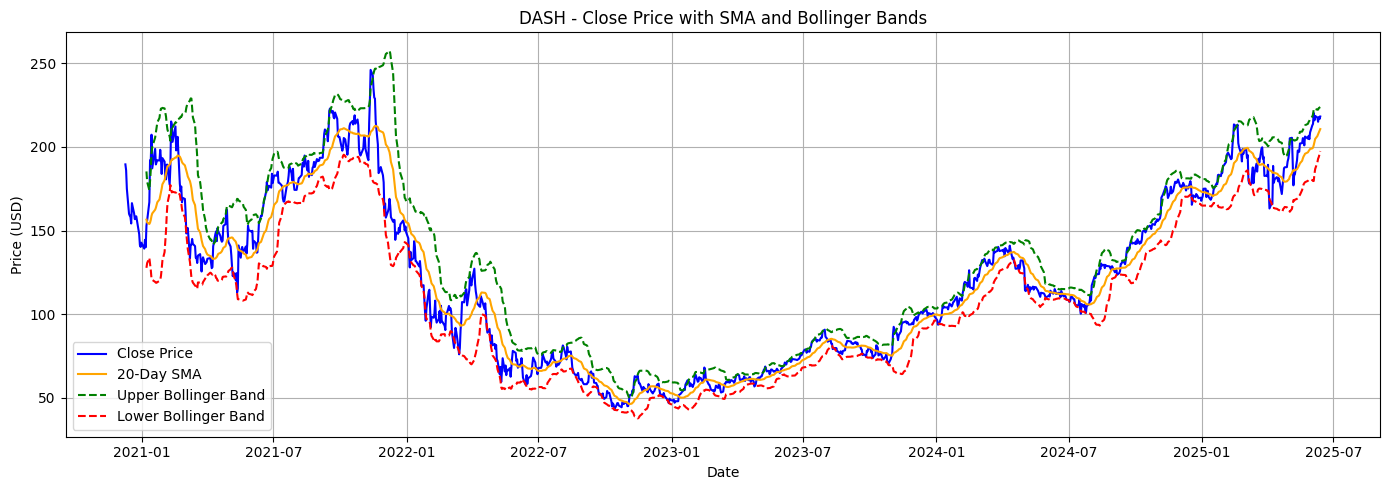

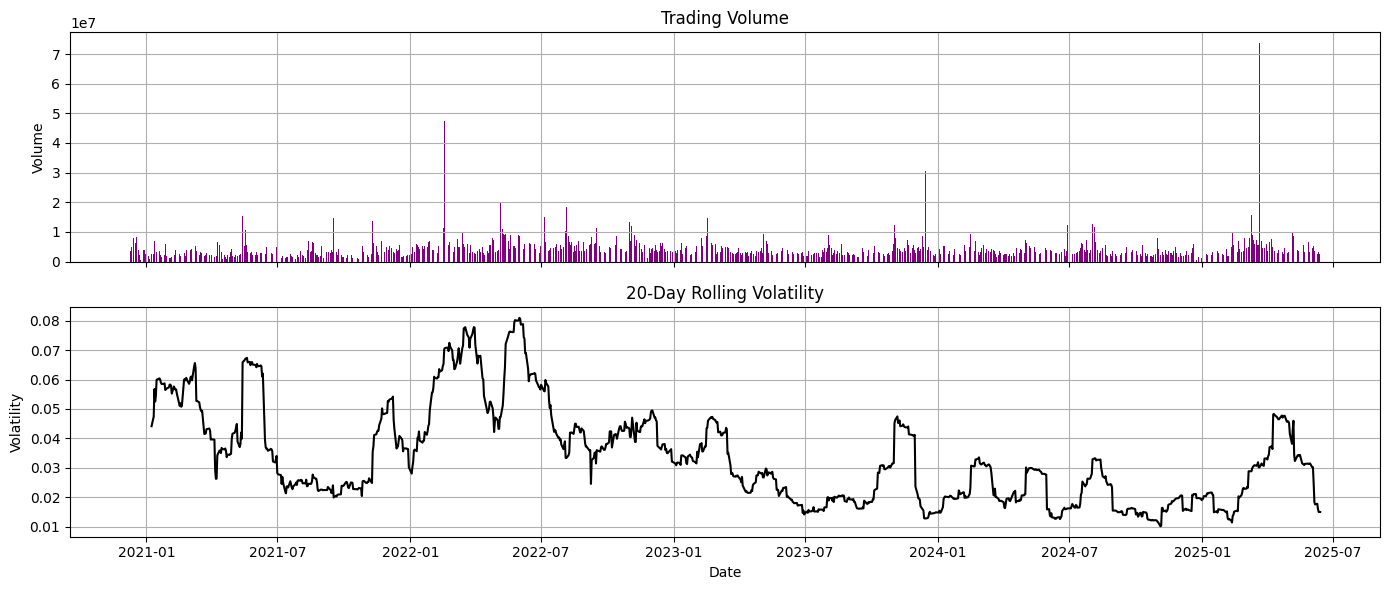

In [16]:
# Main plot: Close price + SMA + Bollinger Bands
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["Close"], label="Close Price", color="blue")
plt.plot(df["Date"], df["20D SMA"], label="20-Day SMA", color="orange")
plt.plot(df["Date"], df["Upper Band"], label="Upper Bollinger Band", color="green", linestyle="--")
plt.plot(df["Date"], df["Lower Band"], label="Lower Bollinger Band", color="red", linestyle="--")
plt.title("DASH - Close Price with SMA and Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Subplots: Volume and Volatility
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 6), sharex=True, 
                               gridspec_kw={"height_ratios": [1, 1]})
fig.subplots_adjust(hspace=0.3)

# Volume plot
ax1.bar(df["Date"], df["Volume"], color="purple")
ax1.set_title("Trading Volume")
ax1.set_ylabel("Volume")
ax1.grid(True)

# Volatility plot
ax2.plot(df["Date"], df["20D Volatility"], color="black")
ax2.set_title("20-Day Rolling Volatility")
ax2.set_xlabel("Date")
ax2.set_ylabel("Volatility")
ax2.grid(True)

plt.tight_layout()
plt.show()

The chart illustrates the **closing price** of DoorDash (DASH) over time, along with the **20-day simple moving average (SMA)** and **Bollinger Bands**. The SMA provides a **smoothed trend line** by averaging the past 20 days of closing prices, while the Bollinger Bands are constructed at **±2 standard deviations** from the SMA to represent **dynamic volatility thresholds**.

Several observations can be made from the plot:

- **Significant price swings** are visible between **2021 and 2022**, with sharp upward movements followed by notable declines. Prices **peaked near \$250** in late 2021 and **fell below \$50** in late 2022.
- The **Bollinger Bands widen** substantially during periods of **high volatility**, such as in **mid-2021 and mid-2022**, and **narrow** during more **stable periods** like 2023.
- When the **price moves outside** the upper or lower band, it may indicate potential **overbought or oversold conditions**. These movements can serve as early **warnings of short-term reversals**.
- The **SMA** follows the general direction of the **price trend** and helps identify periods of **sustained upward or downward movement**.




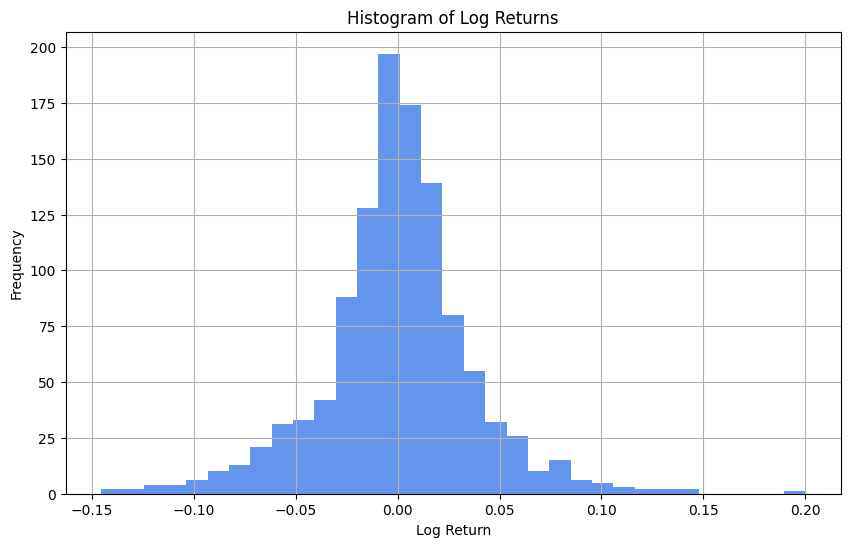

In [17]:
# Histogram of log returns
recommended_bins = int(np.sqrt(len(df["Log Return"]))) # sqrt(number_of_samples) is used here to determine the recommended number of histogram bins based on the square root of the sample size helping with readability

plt.figure(figsize=(10, 6))
plt.hist(df["Log Return"].dropna(), bins=recommended_bins, color='cornflowerblue')
plt.title("Histogram of Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid()

The histogram shows the **distribution of daily log returns** for DoorDash (DASH). Most values are **clustered around zero**, with the highest frequency between **−0.02 and +0.02**.

The shape is **peaked with fat tails**, suggesting that **small returns are common**, but **extreme returns** (beyond ±0.10) also occur occasionally. This highlights **non-normal behavior** in DASH’s return profile and reflects **underlying market risk**.


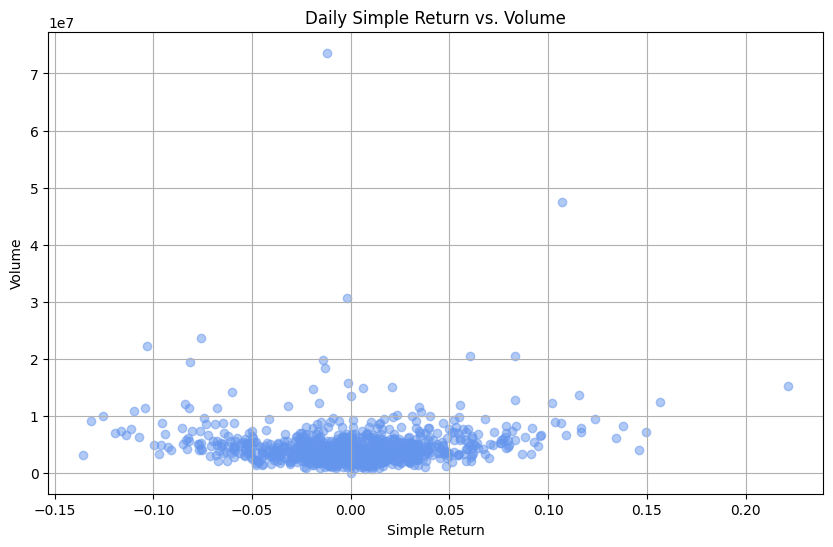

In [18]:
# Sccatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df["Simple Return"], df["Volume"], alpha=0.5, color='cornflowerblue')
plt.title("Daily Simple Return vs. Volume")
plt.xlabel("Simple Return")
plt.ylabel("Volume")
plt.grid()
plt.show()

This scatter plot displays the relationship between **daily simple returns** and **trading volume** for DASH.

The plot shows **no strong linear relationship** between volume and return. Most data points are **clustered near zero return** and **moderate volume**. However, some **extreme returns** and **volume spikes** are visible, suggesting that **unusual market activity** can accompany large price movements, though not consistently.

## Final Recommendations

#### Analyst 1
Between 2020 and 2025, DoorDash’s stock displayed sharp price swings, peaking at $257.25 in November 2021 and reaching lowest at $41.37 in October 2022. These fluctuations were accompanied by highly elevated volatility levels, with the 20-day rolling volatility reaching 0.0806 in June 2022. While some of this movement might reflect broader market conditions, it also indicates that the stock is highly reactive to investor sentiment or momentum shifts. The return of volatility in early 2025, rising to around 0.04, suggests that uncertainty still persists within the stock.

DoorDash appears to follow a cyclical volatility pattern, with relatively calmer phases in 2023–2024 followed by renewed market activity. For investors, this means that entry timing matters. The technical indicators alone suggest that while there may be upward momentum potential, the stock's behavior still carries a lot of risk. Timing would be a very critical factor for any future stake increase.

#### Analyst 2
DoorDash’s volatility in 2022 is hard to be explained, unless looked at from many perspectives. For instance, that year a lot of monetary policy changes were aimed at fighting a growing inflation in the US which certainly triggered sell-offs in the growth-oriented technology sectors. Simultaneously, the food delivery industry also faced a broader reset in valuations, as the demand slowed down after the pandemic. 
DoorDash, being a high-growth tech platform but operating in a maturing market of food delivery could have been particularly exposed and affected by the changes. However, the technical recovery from 2023 onward shows some reassurance. Bollinger Band breakouts and an upward 20-day SMA trend suggest investor optimism. Still, this improvement must be interpreted cautiously, as macro risks remain especially in the current geopolitical state. More safety is needed if the valuation continues to be sensitive to interest rate shifts and competition within the delivery space increases. These trends highlight the need for a flexible and careful investment strategy.

#### Analyst 3
Based on the historical analysis of DoorDash’s stock performance, the recommendation is to hold off on increasing the stake in DASH at this time. While the stock demonstrated periods of strong upward momentum, reaching an all-time high in late 2021, the subsequent decline and persistent volatility suggest underlying instability in investor sentiment. The presence of frequent price swings, as highlighted by elevated rolling volatility levels and wide Bollinger Bands, indicates a high-risk profile. Additionally, the distribution of log returns shows a slight negative skew and fat tails, underscoring the potential for abrupt negative price moves.

Furthermore, the volume-return scatter plot reveals a weak or inconsistent relationship, suggesting that increases in trading activity do not reliably correspond to positive price performance. From a risk-adjusted return perspective, this diminishes confidence in a near-term rebound. Given these findings, it is recommended to closely monitor the stock’s behavior around key earnings announcements and broader market movements. Unless there is a significant shift in fundamentals or clear technical indicators of a sustained uptrend, further capital allocation may expose the firm to avoidable downside risk.

#### Analyst 4
Key market inflection points such as spikes in volume and volatility were concentrated between late 2021 and 2022, aligning with DoorDash’s steepest price declines. However, unlike deteriorating equities, these drawdowns were often followed by recovery phases, particularly from 2023 onward, indicating emerging technical resilience. Notably, there was no strong or consistent correlation between trading volume and price direction, suggesting that movements are less driven by speculative noise and more by shifts in investor confidence in DoorDash’s long-term fundamentals. This behavioral shift, combined with stabilizing trendlines and a more moderate volatility profile signals that DoorDash may be transitioning from a high-risk growth stock to a more maturing one. As such, a cautious hold strategy is advised, with gradual stake increases during market pullbacks. 

#### Analyst 5
DoorDash’s return distribution shows clear signs of fat tails, with outlier events in both tails beyond ±10% and higher kurtosis than a normal distribution, which elevates single-day risk and a large price shock can easily cause outsized returns. While such volatility can present trading opportunities, it also raises the stakes for long-term investors. The histogram confirms that while most daily returns cluster within ±0.02, there are enough extreme values to require a careful approach to exposure.
The scatter plot analysis of daily volume versus return didn't reveal a strong linear relationship, but it did show that high-volume days often accompany large price moves. This implies that sudden investor reactions, such as to earnings or macro events, play a significant role in price action. From a risk management perspective, this underlines the need to plan for both upside and downside tail events.

***Based on the overall analysis, it is recommended to hold the current position in DoorDash and increase the stake only if the stock experiences a meaningful price dip and key technical indicators remain positive. Any additional investment should be accompanied by strict risk controls, including stop-loss levels and portfolio diversification.***


